## About

Showing EEG, HR from ECG, HR from watch, accelerometer data for selected range

In [1]:
import sys
import os
sys.path.insert(1, os.path.join("./tools/"))
from helpers import *

In [2]:
# reload library
importlib.reload(sys.modules['helpers'])
from helpers import *

In [3]:
subject_name = "LB3_007_phaseII"
metadata = pd.DataFrame(json.load(open("./tools/subject_metadata_jp.json"))).T

In [4]:
real_start = pd.to_datetime(metadata.loc[subject_name]['Start day/time']).tz_convert(tz)
#time delta between real start and 1970-01-01 00:00
delta = pd.to_datetime(metadata.loc[subject_name]['Start day/time']).tz_convert(tz)-pd.to_datetime('1970-1-1').tz_localize(tz)
delta_time  = delta-pd.to_timedelta(delta.days, unit='days')

In [5]:

start_time_sec = 316553.3581 - 60
end_time_sec = 316603 


#start time with ref to real date but correct time of day
sz_start_real= real_start + pd.to_timedelta(316553.3581, unit='s')
sz_end_real = real_start + pd.to_timedelta(316603, unit='s')

#start time with ref to real date but correct time of day
seg_start_real = real_start + pd.to_timedelta(start_time_sec, unit='s')
seg_end_real = real_start + pd.to_timedelta(end_time_sec, unit='s')

#start time with ref to 1970 date but correct time of day
seg_start_1970= seg_start_real - pd.to_timedelta(delta.days, unit='days')
seg_end_1970 = seg_end_real- pd.to_timedelta(delta.days, unit='days')

In [6]:
#get data from portal
portal_name = metadata.loc[subject_name]['portal_ID']
ds = s.open_dataset(portal_name)

# Get EEG Data

In [7]:
data_pull_min=1
clip_duration_sec =  end_time_sec - start_time_sec
clip_duration_min = clip_duration_sec / 60

# how many data_pull_min minute data pulls are there?
n_iter = int(np.ceil(clip_duration_min / data_pull_min))

eeg_channels = ['LA01',
 'LA02',
 'LA03']

In [8]:
# eeg_all = pd.DataFrame()
# for i in tqdm(range(n_iter)):

#     start_usec = start_time_sec * 1e6 + i * (data_pull_min * 60 * 1e6)
#     if i == n_iter - 1:
#         end_usec = end_time_sec * 1e6
#     else:
#         end_usec = start_usec + (data_pull_min * 60 * 1e6)
#     data, fs = get_iEEG_data(username, pwd_bin_path, portal_name, start_usec, end_usec, select_electrodes=eeg_channels)

#     time = np.linspace(start_usec, end_usec, len(data), endpoint=False)
#     data.index = pd.to_datetime(time, unit='us')

#     eeg_all = eeg_all.append(data)
        

## Read saved data

In [9]:
file = f"../data/eeg_pt-HUP231_start-{start_time_sec}_end-{end_time_sec}.h5" %()
eeg_all = pd.read_hdf(file, key='ieeg')

In [10]:
#shift to real time
eeg_all.index = eeg_all.index + pd.to_datetime('1970-1-1').tz_localize(tz) + delta

In [11]:
eeg_channels = eeg_all.columns[[16,17,18,25]]

## Shifting time and cut data

In [12]:
#shift to realtime
# eeg_all.index = eeg_all.index.tz_localize(tz) + delta

# #shift back to 1970
# eeg_all.index = eeg_all.index - pd.to_timedelta(delta.days, unit='days')


In [15]:
#fetch saved ecg hr, watch and acc data
data_root = "/gdrive/public/DATA/Human_Data/LB3_PIONEER/"
ecg_hr = fetch_h5(subject_name, data_root, "ecg_heart")
watch_hr = fetch_h5(subject_name, data_root, "watch_heart")
watch_acc = fetch_h5(subject_name, data_root, "watch_acc")


# #shift ecg/wearables data to 1970 keeping time correct
# ecg_hr.index= ecg_hr.index - pd.to_timedelta(delta.days, unit='days')
# watch_hr.index= watch_hr.index - pd.to_timedelta(delta.days, unit='days')
# watch_acc.index= watch_acc.index - pd.to_timedelta(delta.days, unit='days')

# #cutting data to selected range
ecg_hr = ecg_hr[(ecg_hr.index>seg_start_real) & (ecg_hr.index< seg_end_real)]
watch_hr = watch_hr[(watch_hr.index>seg_start_real) & (watch_hr.index< seg_end_real)]
watch_acc = watch_acc[(watch_acc.index>seg_start_real) & (watch_acc.index< seg_end_real)]

# Calc Acc magnitude
watch_acc['mag'] = np.sqrt(np.sum(watch_acc**2, axis=1))

['ecg_heart.h5']
['watch_heart.h5']
['watch_acc.h5']


## Plotting selected data

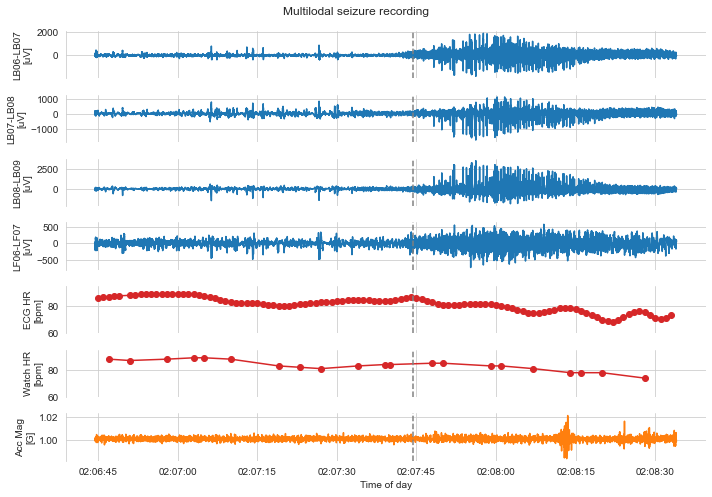

In [16]:
rw = len(eeg_channels)+3

fig, ax = plt.subplots(rw, 1, figsize=(10,rw), sharex=True)
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 10})

for i in range(len(eeg_channels)):
    axi = ax[i]
    axi.plot(eeg_all.index, eeg_all[eeg_channels[i]])
    axi.set_ylabel("%s\n[uV]" %(eeg_channels[i]))
    

axi = ax[len(eeg_channels)]
axi.plot(ecg_hr.index, ecg_hr['heartRate'],'o-', color='C3')
axi.set_ylabel("ECG HR\n[bpm]")
axi.set_ylim([60,95])

axi = ax[len(eeg_channels)+1]
axi.plot(watch_hr['heartRate'].dropna(),'o-', color='C3')
axi.set_ylabel("Watch HR\n[bpm]")
axi.set_ylim([60,95])

axi = ax[len(eeg_channels)+2]
axi.plot(watch_acc.index, watch_acc['mag'], color='C1')
axi.set_ylabel("Acc Mag\n[G]")
axi.set_xlabel("Time of day")

for a in ax:
    a.axvline(x=sz_start_real, ls='--', color='grey')


# xformatter = matplotlib.dates.DateFormatter('%H:%M')
# axi.xaxis.set_major_formatter(xformatter)

plt.suptitle("Multilodal seizure recording")
sns.despine(bottom=True)


plt.tight_layout()
# plt.savefig("./../../figures/%s_%s_%s.png" %(subject_name,start_time_sec,end_time_sec), dpi = 300, bbox_inches='tight')
plt.show()

### Practicing Plotting Different Time Points of the Data

In [17]:
subject_name = "LB3_007_phaseII"
metadata = pd.DataFrame(json.load(open("./tools/subject_metadata_jp.json"))).T

In [18]:
# for time alignment purposes (PHI protection)

real_start = pd.to_datetime(metadata.loc[subject_name]['Start day/time']).tz_convert(tz)
#time delta between real start and 1970-01-01 00:00
delta = pd.to_datetime(metadata.loc[subject_name]['Start day/time']).tz_convert(tz)-pd.to_datetime('1970-1-1').tz_localize(tz)
delta_time  = delta-pd.to_timedelta(delta.days, unit='days')

In [19]:
#get data from portal
portal_name = metadata.loc[subject_name]['portal_ID']
ds = s.open_dataset(portal_name)

In [20]:

start_time_sec = 315961
end_time_sec = 315961 + 60 

In [21]:
# for time alignment purposes (PHI protection)

# FOR START OF SEIZURE (NOT 60s BEFORE THE SEIZURE):
#start time with ref to real date but correct time of day
# sz_start_real= real_start + pd.to_timedelta(316553.3581, unit='s')
# sz_end_real = real_start + pd.to_timedelta(316603, unit='s')

#start time with ref to real date but correct time of day
seg_start_real= real_start + pd.to_timedelta(start_time_sec, unit='s')
seg_end_real = real_start + pd.to_timedelta(end_time_sec, unit='s')

#start time with ref to 1970 date but correct time of day
seg_start_1970= seg_start_real - pd.to_timedelta(delta.days, unit='days')
seg_end_1970 = seg_end_real- pd.to_timedelta(delta.days, unit='days')

In [22]:
# getting EEG data

data_pull_min=1
clip_duration_sec =  end_time_sec - start_time_sec
clip_duration_min = clip_duration_sec / 60

# how many data_pull_min minute data pulls are there?
n_iter = int(np.ceil(clip_duration_min / data_pull_min))

eeg_channels = ['LA01',
 'LA02',
 'LA03']

In [23]:
# getting ECG & watch data 

#fetch saved ecg hr, watch and acc data
data_root = "/gdrive/public/DATA/Human_Data/LB3_PIONEER/"
ecg_hr = fetch_h5(subject_name, data_root, "ecg_heart")
watch_hr = fetch_h5(subject_name, data_root, "watch_heart")
watch_acc = fetch_h5(subject_name, data_root, "watch_acc")


# #shift ecg/wearables data to 1970 keeping time correct
# ecg_hr.index= ecg_hr.index - pd.to_timedelta(delta.days, unit='days')
# watch_hr.index= watch_hr.index - pd.to_timedelta(delta.days, unit='days')
# watch_acc.index= watch_acc.index - pd.to_timedelta(delta.days, unit='days')

print(np.sum(watch_hr.index>seg_start_real))
print(np.sum(watch_hr.index>seg_end_real))
print(np.diff(watch_hr))
print(seg_start_real, seg_end_real)



# #cutting data to selected range
ecg_hr = ecg_hr[(ecg_hr.index>seg_start_real) & (ecg_hr.index< seg_end_real)]
watch_hr = watch_hr[(watch_hr.index>seg_start_real) & (watch_hr.index< seg_end_real)]
watch_acc = watch_acc[(watch_acc.index>seg_start_real) & (watch_acc.index< seg_end_real)]

# Calc Acc magnitude
watch_acc['mag'] = np.sqrt(np.sum(watch_acc**2, axis=1))



['ecg_heart.h5']
['watch_heart.h5']
['watch_acc.h5']
42817
42805
[[ nan  nan]
 [ nan  nan]
 [ nan  nan]
 ...
 [ nan  nan]
 [ nan  nan]
 [-35. 874.]]
2022-03-28 01:57:52-04:00 2022-03-28 01:58:52-04:00


In [24]:
watch_hr.index

DatetimeIndex(['2022-03-28 01:57:58-04:00', '2022-03-28 01:58:04-04:00',
               '2022-03-28 01:58:07-04:00', '2022-03-28 01:58:13-04:00',
               '2022-03-28 01:58:18-04:00', '2022-03-28 01:58:22-04:00',
               '2022-03-28 01:58:28-04:00', '2022-03-28 01:58:30-04:00',
               '2022-03-28 01:58:35-04:00', '2022-03-28 01:58:41-04:00',
               '2022-03-28 01:58:48-04:00', '2022-03-28 01:58:51-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='timeStamp', freq=None)

In [25]:
ecg_hr.index

DatetimeIndex(['2022-03-28 01:57:53-04:00', '2022-03-28 01:57:54-04:00',
               '2022-03-28 01:57:55-04:00', '2022-03-28 01:57:56-04:00',
               '2022-03-28 01:57:57-04:00', '2022-03-28 01:57:58-04:00',
               '2022-03-28 01:57:59-04:00', '2022-03-28 01:58:00-04:00',
               '2022-03-28 01:58:01-04:00', '2022-03-28 01:58:02-04:00',
               '2022-03-28 01:58:03-04:00', '2022-03-28 01:58:04-04:00',
               '2022-03-28 01:58:05-04:00', '2022-03-28 01:58:06-04:00',
               '2022-03-28 01:58:07-04:00', '2022-03-28 01:58:08-04:00',
               '2022-03-28 01:58:09-04:00', '2022-03-28 01:58:10-04:00',
               '2022-03-28 01:58:11-04:00', '2022-03-28 01:58:12-04:00',
               '2022-03-28 01:58:13-04:00', '2022-03-28 01:58:14-04:00',
               '2022-03-28 01:58:15-04:00', '2022-03-28 01:58:16-04:00',
               '2022-03-28 01:58:17-04:00', '2022-03-28 01:58:18-04:00',
               '2022-03-28 01:58:19-04:00', '2022-0

In [26]:
watch_acc.index

DatetimeIndex(['2022-03-28 01:57:52.010000-04:00',
               '2022-03-28 01:57:52.030000-04:00',
               '2022-03-28 01:57:52.050000-04:00',
               '2022-03-28 01:57:52.070000-04:00',
               '2022-03-28 01:57:52.090000-04:00',
               '2022-03-28 01:57:52.111000-04:00',
               '2022-03-28 01:57:52.131000-04:00',
               '2022-03-28 01:57:52.151000-04:00',
               '2022-03-28 01:57:52.171000-04:00',
               '2022-03-28 01:57:52.191000-04:00',
               ...
               '2022-03-28 01:58:51.787000-04:00',
               '2022-03-28 01:58:51.807000-04:00',
               '2022-03-28 01:58:51.847000-04:00',
               '2022-03-28 01:58:51.867000-04:00',
               '2022-03-28 01:58:51.887000-04:00',
               '2022-03-28 01:58:51.907000-04:00',
               '2022-03-28 01:58:51.927000-04:00',
               '2022-03-28 01:58:51.947000-04:00',
               '2022-03-28 01:58:51.967000-04:00',
            

In [27]:
# read saved data

file = f"../data/eeg_pt-HUP231_start-{start_time_sec}_end-{end_time_sec}.h5" %()
eeg_all = pd.read_hdf(file, key='ieeg')

#shift to real time
eeg_all.index = eeg_all.index + pd.to_datetime('1970-1-1').tz_localize(tz) + delta


In [28]:
eeg_all

,LA01-LA02,LA02-LA03,LA03-LA04,LA04-LA05,LA05-LA06,LA06-LA07,LA07-LA08,LA08-LA09,LA09-LA10,LA10-LA11,...,RZ02-RZ03,RZ03-RZ04,RZ04-RZ05,RZ05-RZ06,RZ06-RZ07,RZ07-RZ08,RZ08-RZ09,RZ09-RZ10,RZ10-RZ11,RZ11-RZ12
2022-03-28 01:57:52-04:00,6.634303,-0.764089,13.022788,8.012216,-23.074690,-19.958212,2.390477,5.416511,20.934266,39.062152,...,35.091847,29.388190,9.684454,39.323604,32.302625,-37.548844,-35.067144,-15.278298,3.924225,3.741468
2022-03-28 01:57:52.000976578-04:00,8.048534,-0.217392,11.800053,8.087296,-23.648243,-20.011539,2.428342,4.274547,21.606432,39.944185,...,33.062925,31.734537,10.585574,40.886082,31.767968,-34.653209,-37.707850,-15.152087,3.498069,4.158621
2022-03-28 01:57:52.001953157-04:00,9.617508,-0.041151,10.942103,8.257203,-24.529150,-19.956614,2.623011,3.077501,22.073324,40.561090,...,31.424701,34.011350,11.421810,42.716597,31.424346,-32.433110,-40.518036,-14.638304,3.099495,4.436244
2022-03-28 01:57:52.002929735-04:00,11.217233,-0.370450,10.529732,8.571909,-25.644259,-19.656611,2.968718,1.864160,22.212173,40.777547,...,30.451659,36.106909,12.211856,45.081658,31.476551,-31.514225,-43.660250,-13.441456,2.760594,4.518238
2022-03-28 01:57:52.003906314-04:00,12.501199,-1.082943,10.347633,9.019411,-26.565692,-18.949853,3.289076,0.766971,22.007312,40.651698,...,30.258020,37.850657,13.090084,48.213685,32.102105,-32.367713,-47.234459,-11.454947,2.510797,4.445342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-28 01:58:51.996093686-04:00,-20.349523,14.039461,13.889905,0.793407,-13.399805,19.839371,-1.941850,14.654897,2.109626,6.153853,...,-6.456190,-0.861439,-4.918073,2.852204,-18.761246,29.137231,-46.736367,42.594431,-2.737013,-2.760628
2022-03-28 01:58:51.997070265-04:00,-17.330299,12.382024,7.427709,0.767319,-5.774550,13.863310,-1.975770,14.084350,2.094732,5.864725,...,-5.868194,-0.609357,-4.072985,3.296689,-18.242055,27.781737,-45.360160,40.320058,-2.833039,-2.660264
2022-03-28 01:58:51.998046843-04:00,-17.566741,12.639327,3.454339,1.358011,-0.513411,8.539616,-1.705017,13.572277,1.872983,5.682197,...,-5.548228,-0.267884,-2.837118,3.557233,-17.688254,26.266153,-43.946767,37.986191,-2.942089,-2.597884
2022-03-28 01:58:51.999023422-04:00,-19.069953,13.594914,2.111675,2.613213,1.187378,4.422937,-1.069709,13.119979,1.393708,5.675139,...,-5.483788,0.114099,-1.095596,3.553549,-16.916590,24.373030,-42.331458,35.339358,-3.041753,-2.545406


In [29]:
eeg_channels = eeg_all.columns[[16,17,18,25]]

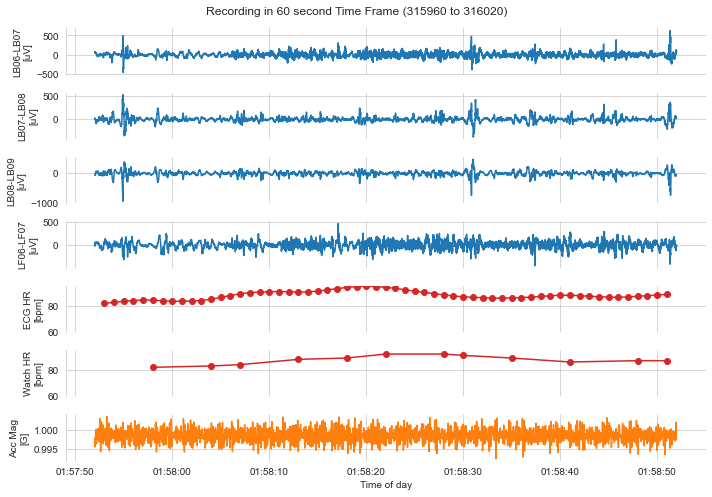

In [30]:
# plotting selected data...

rw = len(eeg_channels)+3    # len(eeg_channels) = 4 --> +3 --> = 7

fig, ax = plt.subplots(rw, 1, figsize=(10,rw), sharex=True)
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 10})

# plots for the 4 EEG channels
for i in range(len(eeg_channels)):      # 0, 1, 2, 3
    axi = ax[i]
    axi.plot(eeg_all.index, eeg_all[eeg_channels[i]])
    axi.set_ylabel("%s\n[uV]" %(eeg_channels[i]))
    
# plot for the ECG data (heart rate)
axi = ax[len(eeg_channels)]
axi.plot(ecg_hr.index, ecg_hr['heartRate'],'o-', color='C3')
axi.set_ylabel("ECG HR\n[bpm]")
axi.set_ylim([60,95])

# plot for the watch heart rate
axi = ax[len(eeg_channels)+1]
axi.plot(watch_hr['heartRate'].dropna(),'o-', color='C3')
axi.set_ylabel("Watch HR\n[bpm]")
axi.set_ylim([60,95])

# plot for the watch accelerometer 
axi = ax[len(eeg_channels)+2]
axi.plot(watch_acc.index, watch_acc['mag'], color='C1')
axi.set_ylabel("Acc Mag\n[G]")
axi.set_xlabel("Time of day")

# adding a vertical line across the axes at x = seizure start time 
        # (this does not apply in this case; I am plotting non-seizure data)
# for a in ax:
    # a.axvline(x=sz_start_real, ls='--', color='grey')


# xformatter = matplotlib.dates.DateFormatter('%H:%M')
# axi.xaxis.set_major_formatter(xformatter)

plt.suptitle("Recording in 60 second Time Frame (315960 to 316020)")
sns.despine(bottom=True)


plt.tight_layout()
# plt.savefig("./../../figures/%s_%s_%s.png" %(subject_name,start_time_sec,end_time_sec), dpi = 300, bbox_inches='tight')
plt.show()

### Trying to Use pyHRV & BioSPPy

BioSPPy:

In [31]:
# ecg_hr 
from biosppy import storage
import pylab as pl 

signal, mdata = storage.load_txt('/gdrive/public/DATA/Human_Data/LB3_PIONEER/LB3_007_phaseII/ecg_heart')

fs = mdata['sampling_rate'] # sampling rate
n = len(signal) # number of samples
t = (n-1)/fs    # duration of signal 

ts = np.linspace (0, t, n, endpoint=False)  # relative timestamps 
pl.plot(ts, signal, lw=2)
pl.grid()
pl.show()


FileNotFoundError: [Errno 2] No such file or directory: '/gdrive/public/DATA/Human_Data/LB3_PIONEER/LB3_007_phaseII/ecg_heart'

In [ ]:
from biosppy.signals import ecg

out = ecg.ecg(signal=signal, sampling_rate=fs, show=True)

NameError: name 'fs' is not defined

pyHRV:

In [ ]:
from pyhrv import hrv
from opensignalsreader import OpenSignalsReader
from biosppy.signals.ecg import ecg 

# file path 
fpath = '/gdrive/public/DATA/Human_Data/LB3_PIONEER/LB3_007_phaseII/ecg_heart'

# load acquisition file
acq = OpenSignalsReader(fpath)

# get the ecg signal 
signal = acq.signal('ECG')

ModuleNotFoundError: No module named 'opensignalsreader'

In [ ]:
# filtering the signal (removing motion artifacts) + extract R-peak locations (R-peak of the QRS complex of an ECG signal)
filtered_signal = ecg(signal)[1]

# compute all HRV parameters
results = hrv(signal=filtered_signal)
# compute all HRV parameters and show all plot figures
results = pyhrv.hrv(signal=signal, show=True)

# Print all the parameters keys and values individually
for key in results.keys():
   print(key, results[key])





TypeError: 'module' object is not callable